# Курсовой проект "Прогнозирование цен на недвижимость"

## Подготовка среды программирования

### Импортирование библиотек и скриптов

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as sps

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
%matplotlib inline

In [16]:
matplotlib.rcParams.update({'font.size': 14})

### Создание функции для оценки работы модели

In [17]:
def evaluate_preds(train_true_values, train_pred_values, valid_true_values, valid_pred_values):
    
    """Оценка качества работы модели с помощью коэффициента детерминации и визуализация резальтатов"""
    
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Valid R2:\t" + str(round(r2(valid_true_values, valid_pred_values), 3)))
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))

    ax1, ax2 = ax.flatten()

    ax1.scatter(x=train_pred_values, y=train_true_values, c='darkviolet', edgecolors='plum')
    ax1.set_xlabel('Predicted values')
    ax1.set_ylabel('True values')
    ax1.set_title('Train sample prediction')

    ax2.scatter(x=valid_pred_values, y=valid_true_values, c='darkviolet', edgecolors='plum')
    ax2.set_xlabel('Predicted values')
    ax2.set_ylabel('True values')
    ax2.set_title('Valid sample prediction')

    plt.show()

### Создание переменных с путями к файлам с тренировочным и тестовым наборами данных

In [18]:
TRAIN_DATASET_PATH = 'C:/Python_Ed/Python_Libraries/Course_Project/project_data_from_kaggle/train.csv'
TEST_DATASET_PATH = 'C:/Python_Ed/Python_Libraries/Course_Project/project_data_from_kaggle/test.csv'
SUBMISSION_PATH = 'C:/Python_Ed/Python_Libraries/Course_Project/project_data_from_kaggle/sample_submission.csv'

## Загрузка DF-ов с тренировочными и тестовыми данными и их обзор

**Описание наборов данных**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

### Загрузка DF-ов

In [19]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [20]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


#### Проверка идентичности горизонтальных размеров DF-ов (учитывая отсутствие столбца 'Price' в test_df)

In [21]:
train_df.shape[1]-1 == test_df.shape[1]

True

##### Число столбцов в DF-ах идентично, что косвенно подтверждает полноценность загруженной информации

### Проверка и модификация типов данных в столбцах DF-ов

In [22]:
def df_types(df):
    
    """Приведение типов данных"""
    
    df['Id'] = df['Id'].astype(str)
    df['DistrictId'] = df['DistrictId'].astype(str)
    
    return df.dtypes

In [23]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [24]:
df_types(train_df)

Id                object
DistrictId        object
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [25]:
test_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

In [26]:
df_types(test_df)

Id                object
DistrictId        object
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

### Обзор данных

#### Целевая переменная (Price)

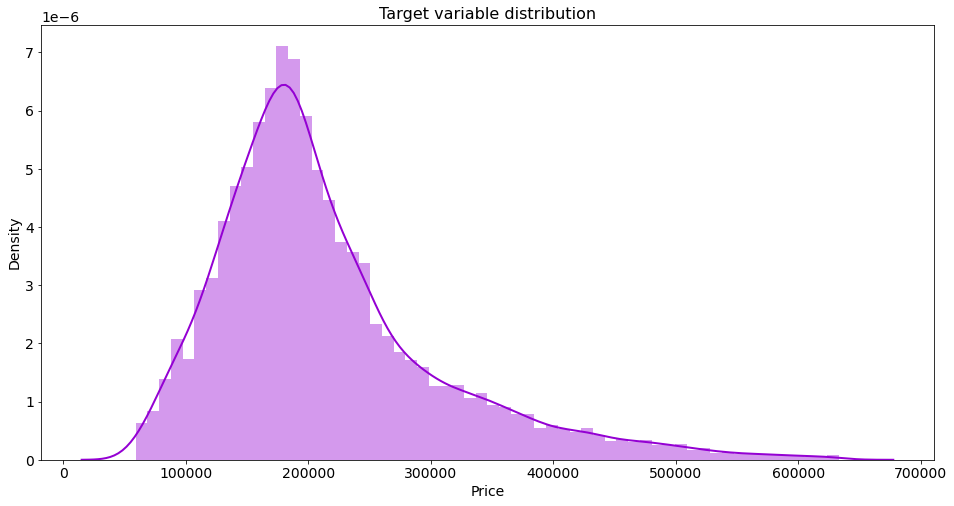

In [27]:
plt.figure(figsize = (16, 8))

sns.distplot(train_df['Price'], bins=60, color='darkviolet', kde_kws={'linewidth': 2})
plt.xlabel('Price')
plt.ylabel('Density')

plt.title('Target variable distribution', fontsize=16)
plt.show()

##### Целевая переменная (Price) демонстрирует логнормальное распределение, оптимальное для величин данного типа

#### Элементарный статистический анализ прочих количественных переменных

In [28]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [29]:
test_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


##### В обоих наборах данных наблюдаются точечные вскакивающие и нереалистичные значения количественных переменных, в столбцах 'LifeSquare' и 'Healthcare_1' отсутствует часть информации (имеются выпадающие значения)

#### Изучение категориальных переменных

In [30]:
def cat_vars(df, title):
    
    """Оценка разнообразия значений категориальных переменных"""
    
    cat_colnames = df.select_dtypes(include='object').columns.tolist()
    
    for cat_colname in cat_colnames[2:]:
        print(f'{cat_colname}\n\n{df[cat_colname].value_counts()}\n{"*" * 100}\n')
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))

    ax1, ax2, ax3 = ax.flatten()

    ax1.pie(np.array(df[cat_colnames[2]].value_counts()), labels=np.array(df[cat_colnames[2]].value_counts().index), colors=['darkviolet', 'plum'])
    ax1.axis('equal')
    ax1.set_title(cat_colnames[2])

    ax2.pie(np.array(df[cat_colnames[3]].value_counts()), labels=np.array(df[cat_colnames[3]].value_counts().index), colors=['darkviolet', 'plum'])
    ax2.axis('equal')
    ax2.set_title(cat_colnames[3])

    ax3.pie(np.array(df[cat_colnames[4]].value_counts()), labels=np.array(df[cat_colnames[4]].value_counts().index), colors=['darkviolet', 'plum'])
    ax3.axis('equal')
    ax3.set_title(cat_colnames[4])
    

    fig.suptitle(title, fontsize=16, y=1.05)  
    plt.show()

Ecology_2

B    9903
A      97
Name: Ecology_2, dtype: int64
****************************************************************************************************

Ecology_3

B    9725
A     275
Name: Ecology_3, dtype: int64
****************************************************************************************************

Shops_2

B    9175
A     825
Name: Shops_2, dtype: int64
****************************************************************************************************



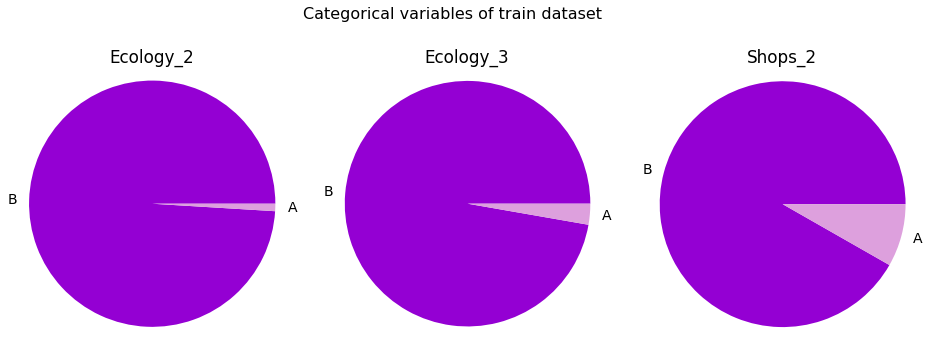

In [31]:
cat_vars(train_df, title='Сategorical variables of train dataset')

Ecology_2

B    4952
A      48
Name: Ecology_2, dtype: int64
****************************************************************************************************

Ecology_3

B    4851
A     149
Name: Ecology_3, dtype: int64
****************************************************************************************************

Shops_2

B    4588
A     412
Name: Shops_2, dtype: int64
****************************************************************************************************



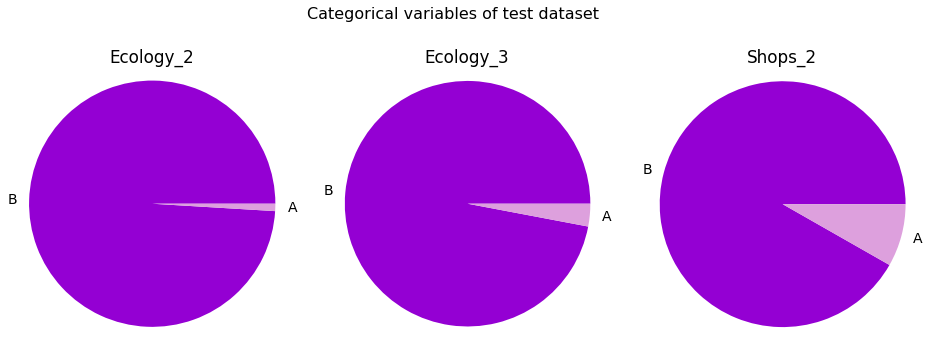

In [32]:
cat_vars(test_df, title='Сategorical variables of test dataset')

##### В тренировочном и тестовом DF-ах в данных столбцов 'Ecology_2', 'Ecology_3' и 'Shops_2' наблюдается выраженный дисбаланс; изучение значений данных столбцов может быть недостаточно полезно

##### Результирующее заключение отбора данных: тренировочный и тестовый наборы данных имеют сходную структуру и содержат информацию сходного качества, требующую преобразований одного рода

## Обработка и модификация данных

### Обработка и модификация выскакивающих и выпадающих значений

In [33]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [34]:
test_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


#### Количество комнат (Rooms)

In [35]:
def rooms(df):
    
    """Обработка значений переменной Rooms"""
    
    df.loc[((df['Rooms'] == 0) | (df['Rooms'] > 6)), 'Rooms'] = rooms_med
    
    return df['Rooms'].value_counts().sort_index(ascending=True)

In [36]:
train_df['Rooms'].value_counts().sort_index(ascending=True)

0.0        8
1.0     3705
2.0     3880
3.0     2235
4.0      150
5.0       18
6.0        1
10.0       2
19.0       1
Name: Rooms, dtype: int64

In [37]:
rooms_med = int(train_df['Rooms'].median())
rooms_med

2

In [38]:
rooms(train_df)

1.0    3705
2.0    3891
3.0    2235
4.0     150
5.0      18
6.0       1
Name: Rooms, dtype: int64

In [39]:
test_df['Rooms'].value_counts().sort_index(ascending=True)

0.0        2
1.0     1769
2.0     2030
3.0     1099
4.0       90
5.0        7
6.0        2
17.0       1
Name: Rooms, dtype: int64

In [40]:
rooms(test_df)

1.0    1769
2.0    2033
3.0    1099
4.0      90
5.0       7
6.0       2
Name: Rooms, dtype: int64

#### Характеристики площади (Square, LifeSquare, KitchenSquare)

##### Сформируем на основе тренировочного набора данных DF со строками без выскакивающих и выпадающих значений в столбцах 'Square', 'LifeSquare' и 'KitchenSquare'

In [41]:
train_df_sq_wo_drop = train_df.loc[((train_df['Square'] < train_df['Square'].quantile(0.99)) &
                                    (train_df['Square'] > train_df['Square'].quantile(0.01))) &
                                    ((train_df['LifeSquare'] < train_df['LifeSquare'].quantile(0.99)) &
                                    (train_df['LifeSquare'] > train_df['LifeSquare'].quantile(0.01))) &
                                    ((train_df['KitchenSquare'] < train_df['KitchenSquare'].quantile(0.99)) &
                                    (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(0.01)))]

train_df_sq_wo_drop.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,7350.000000,7350.000000,7350.000000,7350.000000,7350.000000,7350.000000,7.350000e+03,7350.000000,7350.000000,7350.000000,7350.000000,4236.000000,7350.000000,7350.000000,7350.000000
mean,1.914830,54.099988,35.085038,7.028163,8.096735,12.459456,4.713362e+03,0.123748,29.275374,6257.648027,7.333469,1216.564684,1.560000,4.630476,223505.054269
std,0.808908,16.246749,14.738667,2.976873,4.977131,6.115430,2.338683e+05,0.120599,16.347643,3867.450769,19.460004,1073.563951,1.509305,4.408924,92108.938043
min,1.000000,29.719934,2.861966,1.000000,1.000000,0.000000,1.914000e+03,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.159840,22.877916,5.000000,4.000000,9.000000,1.970000e+03,0.033494,21.000000,3889.000000,1.000000,325.000000,0.000000,1.000000,163653.686340
50%,2.000000,49.998052,32.516889,8.000000,7.000000,12.000000,1.979000e+03,0.089040,29.000000,5731.000000,3.000000,1015.000000,1.000000,4.000000,200749.298127
75%,3.000000,63.798783,44.322030,9.000000,11.000000,17.000000,2.003000e+03,0.195781,39.000000,7759.000000,5.000000,1894.000000,3.000000,6.000000,262297.291871
max,6.000000,117.855969,95.645828,15.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,625678.644994


##### Предполагая, что Square = LifeSquare + KitchenSquare + other_sq, составим DF из строк преобразованного тренировочного DF-а, значения площади в которых удовлетворяют упомянутому условию; полагаем, что в данном DF собраны строки с истинными значениями площадей

In [42]:
train_df_sq_norm = train_df_sq_wo_drop.loc[train_df_sq_wo_drop['Square'] > (train_df_sq_wo_drop['LifeSquare'] + train_df_sq_wo_drop['KitchenSquare'])]
train_df_sq_norm.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6.674000e+03,6674.000000,6674.000000,6674.000000,6674.000000,3978.000000,6674.000000,6674.000000,6674.000000
mean,1.937369,53.983460,33.037601,7.255769,7.912646,12.232694,4.988106e+03,0.125435,30.590351,6511.437818,7.178903,1238.363499,1.629757,4.746629,226448.034028
std,0.809969,16.266501,12.950294,2.700228,4.845370,5.753486,2.454267e+05,0.121526,15.688543,3764.294590,18.230703,1089.209246,1.507667,4.296492,91934.494815
min,1.000000,29.721866,2.861966,1.000000,1.000000,0.000000,1.914000e+03,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.099155,22.471655,6.000000,4.000000,9.000000,1.969000e+03,0.033494,22.000000,4378.000000,1.000000,320.000000,0.000000,2.000000,167136.591361
50%,2.000000,49.823336,31.425134,8.000000,7.000000,12.000000,1.978000e+03,0.090799,30.000000,5776.000000,3.000000,1015.000000,1.000000,4.000000,203192.531952
75%,3.000000,63.479800,41.744458,9.000000,11.000000,17.000000,1.999000e+03,0.194489,39.000000,7960.000000,6.000000,1937.000000,3.000000,6.000000,266004.751513
max,6.000000,117.855969,95.645828,15.000000,42.000000,99.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,625678.644994


##### Реалистичными значениями представлены показатели столбца 'Square' (согласно действующим нормативам, площадь квартиры должна быть не менее 28 квадратных метров), значения столбцов 'LifeSquare' и 'KitchenSquare' требуют корретировок

##### Предположим, что в норме минимальная жилая площадь (LifeSquare) составляет 8 квадратных метров, площадь кухни (KitchenSquare) - 3 квадратных метра, тогда заменим несоответствующие значения в столбцах 'LifeSquare' и 'KitchenSquare' на более оптимальные 

##### Выясним, какую долю от общей площади квартиры (Square) обычно занимают жилые помещения (LifeSquare) и кухня (KitchenSquare) в нормальных условиях

In [43]:
train_df_sq_norm.loc[train_df_sq_norm['LifeSquare'] >= 8].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962
5,5804,99,3.0,62.528465,47.103833,6.0,9,9.0,1972,0.012339,B,B,35,5776,1,2078.0,2,4,B,161044.944138
6,8864,44,1.0,33.938750,21.772930,9.0,1,12.0,1968,0.232205,B,B,24,4860,1,80.0,0,3,B,142402.739272


In [44]:
train_df_sq_norm['LifeSquare_share'] = train_df_sq_norm['LifeSquare'] / train_df_sq_norm['Square']
train_df_sq_norm[['Square', 'LifeSquare', 'LifeSquare_share']].head()

,Square,LifeSquare,LifeSquare_share
1,39.832524,23.169223,0.581666
2,78.342215,47.671972,0.608509
4,64.285067,38.562517,0.599867
5,62.528465,47.103833,0.753318
6,33.938750,21.772930,0.641536


In [45]:
LifeSquare_share_med = train_df_sq_norm['LifeSquare_share'].median()
LifeSquare_share_med

0.6056246754907165

In [46]:
train_df_sq_norm.loc[train_df_sq_norm['KitchenSquare'] >= 3].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_share
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.553407,0.581666
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.720850,0.608509
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.102962,0.599867
5,5804,99,3.0,62.528465,47.103833,6.0,9,9.0,1972,0.012339,...,B,35,5776,1,2078.0,2,4,B,161044.944138,0.753318
6,8864,44,1.0,33.938750,21.772930,9.0,1,12.0,1968,0.232205,...,B,24,4860,1,80.0,0,3,B,142402.739272,0.641536


In [47]:
train_df_sq_norm['KitchenSquare_share'] = train_df_sq_norm['KitchenSquare'] / train_df_sq_norm['Square']
train_df_sq_norm[['Square', 'KitchenSquare', 'KitchenSquare_share']].head()

,Square,KitchenSquare,KitchenSquare_share
1,39.832524,8.0,0.200841
2,78.342215,10.0,0.127645
4,64.285067,9.0,0.140001
5,62.528465,6.0,0.095956
6,33.938750,9.0,0.265184


In [48]:
KitchenSquare_share_med = train_df_sq_norm['KitchenSquare_share'].median()
KitchenSquare_share_med

0.1411863947001799

##### Исходя из полученных медианных значений долей, занимаемых жилыми помещениями и кухней, заменим нереалистичные значения в столбцах 'LifeSquare' и 'KitchenSquare' на произведения общей площади квартиры (Square) и доли, занимаемой в норме соответствующей зоной

In [49]:
train_df_sq_norm.loc[train_df_sq_norm['LifeSquare'] < 8, 'LifeSquare'] = train_df_sq_norm['Square'] * LifeSquare_share_med
train_df_sq_norm.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,LifeSquare_share,KitchenSquare_share
count,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6.674000e+03,6674.000000,6674.000000,6674.000000,6674.000000,3978.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000
mean,1.937369,53.983460,33.556760,7.255769,7.912646,12.232694,4.988106e+03,0.125435,30.590351,6511.437818,7.178903,1238.363499,1.629757,4.746629,226448.034028,0.607740,0.141860
std,0.809969,16.266501,12.490384,2.700228,4.845370,5.753486,2.454267e+05,0.121526,15.688543,3764.294590,18.230703,1089.209246,1.507667,4.296492,91934.494815,0.124544,0.055018
min,1.000000,29.721866,11.047605,1.000000,1.000000,0.000000,1.914000e+03,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,59174.778028,0.035169,0.008781
25%,1.000000,41.099155,22.688375,6.000000,4.000000,9.000000,1.969000e+03,0.033494,22.000000,4378.000000,1.000000,320.000000,0.000000,2.000000,167136.591361,0.550874,0.109734
50%,2.000000,49.823336,31.681409,8.000000,7.000000,12.000000,1.978000e+03,0.090799,30.000000,5776.000000,3.000000,1015.000000,1.000000,4.000000,203192.531952,0.605625,0.141186
75%,3.000000,63.479800,42.080163,9.000000,11.000000,17.000000,1.999000e+03,0.194489,39.000000,7960.000000,6.000000,1937.000000,3.000000,6.000000,266004.751513,0.660680,0.175692
max,6.000000,117.855969,95.645828,15.000000,42.000000,99.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,625678.644994,0.986773,0.397403


In [50]:
train_df_sq_norm.loc[train_df_sq_norm['KitchenSquare'] < 3, 'KitchenSquare'] = train_df_sq_norm['Square'] * KitchenSquare_share_med
train_df_sq_norm.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,LifeSquare_share,KitchenSquare_share
count,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6.674000e+03,6674.000000,6674.000000,6674.000000,6674.000000,3978.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000
mean,1.937369,53.983460,33.556760,7.798034,7.912646,12.232694,4.988106e+03,0.125435,30.590351,6511.437818,7.178903,1238.363499,1.629757,4.746629,226448.034028,0.607740,0.141860
std,0.809969,16.266501,12.490384,2.155869,4.845370,5.753486,2.454267e+05,0.121526,15.688543,3764.294590,18.230703,1089.209246,1.507667,4.296492,91934.494815,0.124544,0.055018
min,1.000000,29.721866,11.047605,3.000000,1.000000,0.000000,1.914000e+03,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,59174.778028,0.035169,0.008781
25%,1.000000,41.099155,22.688375,6.000000,4.000000,9.000000,1.969000e+03,0.033494,22.000000,4378.000000,1.000000,320.000000,0.000000,2.000000,167136.591361,0.550874,0.109734
50%,2.000000,49.823336,31.681409,8.000000,7.000000,12.000000,1.978000e+03,0.090799,30.000000,5776.000000,3.000000,1015.000000,1.000000,4.000000,203192.531952,0.605625,0.141186
75%,3.000000,63.479800,42.080163,9.000000,11.000000,17.000000,1.999000e+03,0.194489,39.000000,7960.000000,6.000000,1937.000000,3.000000,6.000000,266004.751513,0.660680,0.175692
max,6.000000,117.855969,95.645828,16.078747,42.000000,99.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,625678.644994,0.986773,0.397403


##### Если Square = LifeSquare + KitchenSquare + other_sq, то other_sq = Square - LifeSquare - KitchenSquare; добавим столбец other_sq в тренировочный DF с истинными значениями площадей

In [51]:
train_df_sq_norm['other_sq'] = train_df_sq_norm['Square'] - train_df_sq_norm['LifeSquare'] - train_df_sq_norm['KitchenSquare']
train_df_sq_norm[['Square', 'LifeSquare', 'KitchenSquare', 'other_sq']].head()

,Square,LifeSquare,KitchenSquare,other_sq
1,39.832524,23.169223,8.0,8.663301
2,78.342215,47.671972,10.0,20.670243
4,64.285067,38.562517,9.0,16.722551
5,62.528465,47.103833,6.0,9.424632
6,33.938750,21.772930,9.0,3.165820


##### Вычислим медиану доли площади квартиры, отводящейся other_sq в норме

In [52]:
train_df_sq_norm['other_sq_share'] = train_df_sq_norm['other_sq'] / train_df_sq_norm['Square']
train_df_sq_norm[['Square', 'LifeSquare', 'KitchenSquare', 'other_sq', 'other_sq_share']].head()

,Square,LifeSquare,KitchenSquare,other_sq,other_sq_share
1,39.832524,23.169223,8.0,8.663301,0.217493
2,78.342215,47.671972,10.0,20.670243,0.263846
4,64.285067,38.562517,9.0,16.722551,0.260131
5,62.528465,47.103833,6.0,9.424632,0.150725
6,33.938750,21.772930,9.0,3.165820,0.093280


In [53]:
other_sq_share_med = train_df_sq_norm['other_sq_share'].median()
other_sq_share_med

0.24568340086245874

##### Оценим, насколько близка к единице сумма всех трёх независимо найденных медиан долей, приходящихся на различные зоны квартир (LifeSquare, KitchenSquare, other_sq)

In [54]:
all_shares = LifeSquare_share_med + KitchenSquare_share_med + other_sq_share_med
all_shares

0.9924944710533552

##### Значение крайне близко к единице, что свидетельствует о вероятной надёжности экстраполяции вычисленных значений характеристик площади квартир на исходные наборы данных

##### Обратимся снова к исходным тренировочному и тестовому наборам данных для замены нереалистичных и выпадающих значений характеристик площади квартир на более оптимальные, используя полученные результаты

##### Однако перед применением заданного подхода к DF-ам необходимо привести значения столбца 'Square' к реалистичному виду, для этого изучим величины, представленные в данном столбце

In [55]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.888800,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.812096,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,1.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,6.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [56]:
train_df_Square_wo_drop = train_df.loc[(train_df['Square'] < train_df['Square'].quantile(.99)) &
                                       (train_df['Square'] > train_df['Square'].quantile(.01))]
train_df_Square_wo_drop.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,9800.000000,9800.000000,7737.000000,9800.000000,9800.000000,9800.000000,9.800000e+03,9800.000000,9800.000000,9800.000000,9800.000000,5106.000000,9800.000000,9800.000000,9800.000000
mean,1.884592,55.669114,36.752982,6.271429,8.551531,12.679796,4.031038e+03,0.119048,24.767551,5370.852551,7.993061,1136.263024,1.316531,4.238571,213697.811614
std,0.800071,16.911275,86.375915,28.806249,5.216939,6.717752,2.025358e+05,0.119219,17.520098,4005.838231,23.718206,1018.822266,1.490184,4.797908,91040.493335
min,1.000000,29.719934,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.891181,22.875524,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,154530.264091
50%,2.000000,52.513310,32.806000,6.000000,7.000000,14.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192342.953556
75%,2.000000,65.687443,44.978912,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.000000,6.000000,248766.588254
max,6.000000,117.855969,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [57]:
train_df_Square_wo_drop['Square'].corr(train_df_Square_wo_drop['Rooms'])

0.7953240592511414

##### Между количеством комнат в квартире (Rooms) и её площадью (Square) наблюдается положительная линейная корреляция, поэтому наиболее оптимально - подойти к замене нереалистичных значений столбца 'Square', учитывая число комнат в квартире

In [58]:
def square(df):
    
    """Обработка значений переменных Square, LifeSquare, KitchenSquare"""
    
    for i in range(1, 7):
        med = train_df_Square_wo_drop.loc[((train_df_Square_wo_drop['Rooms'] == i) &
                                           (train_df_Square_wo_drop['Square'] >= 28)), 'Square'].median()
        df.loc[((df['Rooms'] == i) & (df['Square'] < 28)), 'Square'] = med
    
    df.loc[((df['Square'] <= (df['LifeSquare'] + df['KitchenSquare'])) |
            (df['KitchenSquare'] < 3)), 'KitchenSquare'] = df['Square'] * KitchenSquare_share_med
    
    df.loc[((df['Square'] <= (df['LifeSquare'] + df['KitchenSquare'])) |
            (df['LifeSquare'] < 8)), 'LifeSquare'] = df['Square'] * LifeSquare_share_med
    
    df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['Square'] - df['KitchenSquare'] - (df['Square'] * other_sq_share_med)
    
    return df.describe()

##### Заменим нереалистичные значения общей площади квартиры, исходя из предположения, что в норме площадь квартиры должна составлять не менее 28 квардратных метров

##### Также заменим нереалистичные значения в столбце 'KitchenSquare', учитывая две гипотезы, описанные ранее:
##### 1) Square = LifeSquare + KitchenSquare + other_sq
##### 2) KitchenSquare >= 3

##### Аналогично заменим нереалистичные значения в столбце 'LifeSquare', учитывая две гипотезы, описанные ранее:
##### 1) Square = LifeSquare + KitchenSquare + other_sq
##### 2) LifeSquare >= 8

##### Заменим выпадающие значения в столбцах 'LifeSquare' тренировочного и тестового DF-ов, зная Square, KitchenSquare и медиану other_sq квартир

In [59]:
square(train_df)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.888800,56.461790,34.174220,8.144772,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.812096,20.889772,13.586605,3.032767,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,1.000000,28.091273,-13.075597,3.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.784623,24.189675,6.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.541997,32.131698,8.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.927434,41.394682,9.616739,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,6.000000,641.065193,388.244899,90.509683,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [60]:
square(test_df)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,1.90780,56.601381,34.308038,8.077861,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,0.81008,18.861720,12.208785,2.777466,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.00000,28.025001,-13.986431,3.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,1.00000,41.912403,24.395053,6.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,2.00000,52.924953,32.498947,8.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,2.00000,66.285129,41.827316,9.682915,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,6.00000,223.453689,122.578932,61.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


##### Описания преобразованных тренировочного и тестового DF-ов демонстрируют наличие отрицательных значений площади, что невозможно в реальных условиях, поэтому проверим DF-ы на соответствие всем названным выше условиям:
##### 1) Square = LifeSquare + KitchenSquare + other_sq
##### 2) LifeSquare >= 8
##### 3) KitchenSquare >= 3

In [61]:
train_df.loc[(train_df['Square'] <= (train_df['LifeSquare'] + train_df['KitchenSquare'])) |
             (train_df['LifeSquare'] < 8) |
             (train_df['KitchenSquare'] < 3)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
682,16593,52,2.0,64.859242,-13.075597,62.0,15,17.0,1977,0.371149,B,B,34,7065,1,750.0,2,5,B,185993.474671
7601,12666,34,2.0,60.603363,36.702892,58.0,14,22.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,261733.472106


In [62]:
test_df.loc[(test_df['Square'] <= (test_df['LifeSquare'] + test_df['KitchenSquare'])) |
            (test_df['LifeSquare'] < 8) |
            (test_df['KitchenSquare'] < 3)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
972,5428,27,2.0,62.326044,-13.986431,61.0,12,17.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A


##### Условиям не соответствуют две строки тренировочного набора данных и одна строка тестового набора данных; видно, что во всех трёх случая кухня имеет нереалистичную площадь (близка к общей площади квартиры), поэтому в указанных строках сначала преобразуем значения столбцов 'KitchenSquare', после чего скорректируем значения столбцов 'LifeSquare'

In [63]:
train_df.loc[((train_df['Square'] <= (train_df['LifeSquare'] + train_df['KitchenSquare'])) |
              (train_df['LifeSquare'] < 8) |
              (train_df['KitchenSquare'] < 3)), 'KitchenSquare'] = train_df['Square'] * KitchenSquare_share_med

train_df.loc[((train_df['Square'] <= (train_df['LifeSquare'] + train_df['KitchenSquare'])) |
              (train_df['LifeSquare'] < 8) |
              (train_df['KitchenSquare'] < 3)), 'LifeSquare'] = train_df['Square'] * LifeSquare_share_med

train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.888800,56.461790,34.179455,8.134544,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.812096,20.889772,13.578480,2.942625,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,1.000000,28.091273,8.822988,3.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.784623,24.193004,6.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.541997,32.133241,8.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.927434,41.394682,9.614004,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,6.000000,641.065193,388.244899,90.509683,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [64]:
test_df.loc[((test_df['Square'] <= (test_df['LifeSquare'] + test_df['KitchenSquare'])) |
              (test_df['LifeSquare'] < 8) |
              (test_df['KitchenSquare'] < 3)), 'KitchenSquare'] = test_df['Square'] * KitchenSquare_share_med

test_df.loc[((test_df['Square'] <= (test_df['LifeSquare'] + test_df['KitchenSquare'])) |
              (test_df['LifeSquare'] < 8) |
              (test_df['KitchenSquare'] < 3)), 'LifeSquare'] = test_df['Square'] * LifeSquare_share_med

test_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,1.90780,56.601381,34.318384,8.067420,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,0.81008,18.861720,12.189755,2.674705,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.00000,28.025001,9.495367,3.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,1.00000,41.912403,24.401994,6.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,2.00000,52.924953,32.509386,8.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,2.00000,66.285129,41.827316,9.681268,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,6.00000,223.453689,122.578932,42.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


#### Высотные характеристики (Floor, HouseFloor)

In [65]:
train_df.loc[train_df['Floor'] > train_df['HouseFloor']].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
17,1190,8,2.0,49.396000,28.299600,5.000000,6,5.0,1962,0.458174,B,A,26,4439,1,1130.0,1,5,B,186971.926566
19,367,45,1.0,42.367289,25.658675,5.981685,16,14.0,2015,0.195781,B,B,23,5212,6,NaN,3,2,B,250466.980777
21,8471,20,3.0,75.611065,47.494621,8.000000,11,9.0,1976,0.019509,B,B,37,7687,11,176.0,5,5,B,366916.246494
24,4717,27,1.0,44.203947,27.102775,6.240996,2,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,135466.559958
25,4521,6,2.0,65.409965,40.104825,9.234997,18,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,191205.272608


In [66]:
test_df.loc[test_df['Floor'] > test_df['HouseFloor']].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
11,13270,9,3.0,80.599472,49.417970,11.379549,4,1.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B
12,5250,96,4.0,87.776382,54.620540,10.000000,25,24.0,2014,0.041116,B,B,53,14892,4,NaN,1,4,B
14,11404,27,1.0,44.415510,27.232491,6.270866,14,1.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
21,3190,9,2.0,64.862396,39.769094,9.157688,7,1.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B
22,15709,48,3.0,86.489935,52.380439,12.211202,24,1.0,2015,0.041125,B,B,46,9515,5,NaN,1,10,B


##### В тренировочном и тестовом наборах данных встречаются строки, в которых в колонке 'Floor' указано значение больше возможного в соответствующей ситуации ('HouseFloor')

##### Можно предположить механическую ошибку оператора при заполнении данных и поменять нереалистичные значения двух столбцов местами, учитывая возможность обнаружения нуля в столбце 'HouseFloor'

In [67]:
def floor(df):
    
    """Обработка значений переменных Floor и HouseFloor"""
    
    df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = df['Floor']
    
    unreal_fl_index_array = np.array(df.loc[df['Floor'] > df['HouseFloor']].index)
    
    for i in unreal_fl_index_array:
        fl = df.loc[i, 'Floor']
        hfl = df.loc[i, 'HouseFloor']
        df.loc[i, 'Floor'] = hfl
        df.loc[i, 'HouseFloor'] = fl
        
    return df.describe()

In [68]:
floor(train_df)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.888800,56.461790,34.179455,8.134544,7.943200,13.435700,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.812096,20.889772,13.578480,2.942625,5.228127,6.094012,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,1.000000,28.091273,8.822988,3.000000,1.000000,1.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.784623,24.193004,6.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.541997,32.133241,8.000000,7.000000,14.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.927434,41.394682,9.614004,11.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,6.000000,641.065193,388.244899,90.509683,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [69]:
floor(test_df)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,1.90780,56.601381,34.318384,8.067420,8.083600,13.395000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,0.81008,18.861720,12.189755,2.674705,5.382639,6.231945,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.00000,28.025001,9.495367,3.000000,1.000000,1.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,1.00000,41.912403,24.401994,6.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,2.00000,52.924953,32.509386,8.000000,7.000000,14.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,2.00000,66.285129,41.827316,9.681268,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,6.00000,223.453689,122.578932,42.000000,46.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


#### Год постройки дома (HouseYear)

In [70]:
train_df['HouseYear'].value_counts().sort_index()

1910          1
1912          2
1914          1
1916          1
1917          3
           ... 
2018        175
2019         79
2020         19
4968          1
20052011      1
Name: HouseYear, Length: 97, dtype: int64

In [71]:
test_df['HouseYear'].value_counts().sort_index()

1908      1
1909      1
1910      1
1911      1
1912      1
       ... 
2016    172
2017    141
2018     73
2019     28
2020      9
Name: HouseYear, Length: 97, dtype: int64

##### В тестовом наборе данных все значения столбца 'HouseYear' выглядят реалистичными, однако два значения столбца 'HouseYear' в тренировочном наборе данных не соответствуют действительности, их необходимо заменить

##### Вероятно, под значением 4968 подразумевалось 1968, а под значением 20052011 - 2005-2011 (т.е. временной промежуток, в который строился дом); таким образом, в тренировочном наборе данных целезообразно заменить 4968 на 1968, а 20052011 - на 2011

In [72]:
train_df.loc[train_df['HouseYear'] == 4968, 'HouseYear'] = int(1968)
train_df.loc[train_df['HouseYear'] == 20052011, 'HouseYear'] = int(2011)
train_df['HouseYear'].value_counts().sort_index()

1910      1
1912      2
1914      1
1916      1
1917      3
       ... 
2016    305
2017    308
2018    175
2019     79
2020     19
Name: HouseYear, Length: 95, dtype: int64

#### Показатели местности (Ecology_n, Social_n, Healthcare_1, Helthcare_2, Shops_n)

##### Недостаточный объём информации о показателях местности не позволяет сформировать справедливые заключения о данных величинах, тем не менее, как отмечалось в ходе обзора данных, в столбце 'Healthcare_1' отсутствует часть информации (имеются выпадающие значения), а значит, необходимо заполнить ячейки с выпадающими значениями адекватными величинами

In [73]:
train_df.loc[train_df['Healthcare_1'].isnull(), :].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,76.767010,10.000000,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
3,2352,1,1.0,40.409907,24.776534,5.705329,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.000000,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962
8,9951,1,1.0,46.887892,28.396464,6.619932,12,20.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,160400.401732
11,16755,88,2.0,53.975144,34.153584,8.000000,2,12.0,1978,0.127376,B,B,43,8429,3,NaN,3,9,B,253124.005332


In [74]:
test_df.loc[test_df['Healthcare_1'].isnull(), :].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
1,5925,62,1.0,42.493907,25.735359,5.999562,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,35.854440,9.000000,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.000000,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
6,672,62,1.0,46.269456,22.820239,11.000000,8,17.0,2014,0.072158,B,B,2,629,1,NaN,0,0,A
7,2471,2,2.0,48.172969,29.924204,6.000000,4,9.0,1974,0.000000,B,B,33,7425,1,NaN,2,5,B


##### Показатель, связанный со здравоохранением теоретически может быть связан с другим подобным показателем (Helthcare_2), а также непосредственно с местностью, для которой измеряется (DistrictId); изучим линейную корреляцию между данными величинами

In [75]:
train_df['Healthcare_1'].corr(train_df['Helthcare_2'])

0.20317742147923248

In [76]:
train_df['Healthcare_1'].corr(train_df['DistrictId'].astype(int))

0.30433529904351125

In [77]:
test_df['Healthcare_1'].corr(test_df['Helthcare_2'])

0.18999427060704696

In [78]:
test_df['Healthcare_1'].corr(test_df['DistrictId'].astype(int))

0.3141522994745202

##### Выраженной линейной зависимости между величинами не обнаружено; в таком случае, в тренировочном и тестовом DF-ах заменим выпадающие значения столбца 'Healthcare_1'  на медиану массива известных значений данного столбца

In [79]:
def Healthcare_1_med(df):
    
    """Замена выпадающих значений переменной Healthcare_1"""
    
    df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].median()
    
    return df.describe()

In [80]:
Healthcare_1_med(train_df)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.888800,56.461790,34.179455,8.134544,7.943200,13.435700,1984.866300,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399
std,0.812096,20.889772,13.578480,2.942625,5.228127,6.094012,18.412271,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865
min,1.000000,28.091273,8.822988,3.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.784623,24.193004,6.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.541997,32.133241,8.000000,7.000000,14.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.927434,41.394682,9.614004,11.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171
max,6.000000,641.065193,388.244899,90.509683,42.000000,117.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [81]:
Healthcare_1_med(test_df)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000
mean,1.90780,56.601381,34.318384,8.067420,8.083600,13.395000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1029.396400,1.31940,4.242800
std,0.81008,18.861720,12.189755,2.674705,5.382639,6.231945,18.573149,0.120070,17.532202,4026.614773,23.863762,766.595258,1.47994,4.777365
min,1.00000,28.025001,9.495367,3.000000,1.000000,1.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,1.00000,41.912403,24.401994,6.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,810.000000,0.00000,1.000000
50%,2.00000,52.924953,32.509386,8.000000,7.000000,14.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,2.00000,66.285129,41.827316,9.681268,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,990.000000,2.00000,6.000000
max,6.00000,223.453689,122.578932,42.000000,46.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


##### Для удобства интерпретации моделью заменим также категориальные переменные на числовые, приняв, что 'A' = 0, 'B' = 1

In [82]:
def cat_to_quant(df):
    
    """Замена категориальных переменных на числовые"""
    
    pattern = {'A': 0, 'B': 1}
    df['Ecology_2'] = df['Ecology_2'].replace(pattern)
    df['Ecology_3'] = df['Ecology_3'].replace(pattern)
    df['Shops_2'] = df['Shops_2'].replace(pattern)
    
    return df.describe()

In [83]:
cat_to_quant(train_df)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.888800,56.461790,34.179455,8.134544,7.943200,13.435700,1984.866300,0.118858,0.990300,0.972500,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,0.917500,214138.857399
std,0.812096,20.889772,13.578480,2.942625,5.228127,6.094012,18.412271,0.119025,0.098015,0.163543,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,0.275139,92872.293865
min,1.000000,28.091273,8.822988,3.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.784623,24.193004,6.000000,4.000000,9.000000,1974.000000,0.017647,1.000000,1.000000,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,1.000000,153872.633942
50%,2.000000,52.541997,32.133241,8.000000,7.000000,14.000000,1977.000000,0.075424,1.000000,1.000000,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,1.000000,192269.644879
75%,2.000000,65.927434,41.394682,9.614004,11.000000,17.000000,2001.000000,0.195781,1.000000,1.000000,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,1.000000,249135.462171
max,6.000000,641.065193,388.244899,90.509683,42.000000,117.000000,2020.000000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,1.000000,633233.466570


In [84]:
cat_to_quant(test_df)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
count,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,1.90780,56.601381,34.318384,8.067420,8.083600,13.395000,1984.392600,0.119874,0.990400,0.970200,24.933800,5406.900000,8.262600,1029.396400,1.31940,4.242800,0.917600
std,0.81008,18.861720,12.189755,2.674705,5.382639,6.231945,18.573149,0.120070,0.097518,0.170052,17.532202,4026.614773,23.863762,766.595258,1.47994,4.777365,0.275001
min,1.00000,28.025001,9.495367,3.000000,1.000000,1.000000,1908.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1.00000,41.912403,24.401994,6.000000,4.000000,9.000000,1973.000000,0.019509,1.000000,1.000000,6.000000,1564.000000,0.000000,810.000000,0.00000,1.000000,1.000000
50%,2.00000,52.924953,32.509386,8.000000,7.000000,14.000000,1977.000000,0.072158,1.000000,1.000000,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000,1.000000
75%,2.00000,66.285129,41.827316,9.681268,12.000000,17.000000,2000.000000,0.195781,1.000000,1.000000,36.000000,7287.000000,5.000000,990.000000,2.00000,6.000000,1.000000
max,6.00000,223.453689,122.578932,42.000000,46.000000,99.000000,2020.000000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000,1.000000


### Построение новых признаков

#### Признак, основанный на расположении квартиры, её площади и цене (DistrictId, Square, Price)

##### Высчитаем медиану цены одного квадратного метра в каждом районе

In [85]:
dist_array = np.array(train_df['DistrictId'])

for dist in dist_array:
    dist_med = (train_df.loc[(train_df['DistrictId'] == dist), 'Price'] / train_df.loc[(train_df['DistrictId'] == dist), 'Square']).median()
    train_df.loc[(train_df['DistrictId'] == dist), 'DistrictPricePerSqM'] = dist_med
    test_df.loc[(test_df['DistrictId'] == dist), 'DistrictPricePerSqM'] = dist_med

In [86]:
train_df['DistrictPricePerSqM'].count() / train_df['DistrictId'].count()

1.0

In [87]:
test_df['DistrictPricePerSqM'].count() / test_df['DistrictId'].count()

0.9984

##### В тестовом наборе данных наблюдаются несколько строк с выпадающими значениями в столбце 'DistrictPricePerSqM', что, вероятно, связано с отсутствием информации о ряде районов в тренировочном наборе данных

In [88]:
test_df.loc[test_df['DistrictPricePerSqM'].isnull()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,DistrictPricePerSqM
1279,14939,210,2.0,54.953826,31.223917,6.0,3,10.0,1956,8.194346e-02,1,1,20,2738,20,900.0,1,4,1,NaN
1979,8845,203,2.0,50.417709,27.587971,7.0,4,5.0,1977,1.501689e-02,1,1,17,3079,59,2890.0,0,8,1,NaN
2280,9155,204,3.0,88.559337,62.854221,8.0,7,8.0,1918,3.731645e-02,1,1,32,6748,93,562.0,4,10,1,NaN
2609,14024,198,2.0,47.477281,31.069466,5.0,2,5.0,1970,6.076152e-03,1,1,30,5285,0,645.0,6,6,1,NaN
2674,15655,211,2.0,46.501558,32.276987,5.0,5,5.0,1965,1.800000e-09,1,1,16,3681,73,1815.0,2,5,1,NaN
3723,13382,206,2.0,46.047289,27.384090,6.0,5,7.0,1930,7.815280e-05,1,1,22,6398,141,1046.0,3,23,1,NaN
4807,15748,212,2.0,75.655182,36.877626,15.0,2,7.0,1929,0.000000e+00,1,1,8,1423,37,562.0,1,8,1,NaN
4836,16217,206,4.0,76.428426,50.344903,11.0,6,7.0,1912,4.203159e-02,1,1,37,6856,84,1940.0,2,5,1,NaN


##### Данные районы имеют незначительное представительство в тестовом DF-е (1-2 строки), в связи с чем выявить характерные ценообразующие особенности данных районов тяжело; можно лишь предположить, что значения показателей местности, являющиеся, вероятно, низкими, а также значительный возраст домов в данных районах отрицательно влияют на формирование цен на недвижимость, поэтому ассоциируем выпадающие значения столбца 'DistrictPricePerSqM' с первым квартилем распределения описываемой величины

In [89]:
test_df['DistrictPricePerSqM'] = test_df['DistrictPricePerSqM'].fillna(train_df['DistrictPricePerSqM'].quantile(.25))
test_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,DistrictPricePerSqM
count,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000
mean,1.90780,56.601381,34.318384,8.067420,8.083600,13.395000,1984.392600,0.119874,0.990400,0.970200,24.933800,5406.900000,8.262600,1029.396400,1.31940,4.242800,0.917600,3936.976561
std,0.81008,18.861720,12.189755,2.674705,5.382639,6.231945,18.573149,0.120070,0.097518,0.170052,17.532202,4026.614773,23.863762,766.595258,1.47994,4.777365,0.275001,984.350071
min,1.00000,28.025001,9.495367,3.000000,1.000000,1.000000,1908.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000,0.000000,2270.322237
25%,1.00000,41.912403,24.401994,6.000000,4.000000,9.000000,1973.000000,0.019509,1.000000,1.000000,6.000000,1564.000000,0.000000,810.000000,0.00000,1.000000,1.000000,2949.975415
50%,2.00000,52.924953,32.509386,8.000000,7.000000,14.000000,1977.000000,0.072158,1.000000,1.000000,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000,1.000000,4134.353749
75%,2.00000,66.285129,41.827316,9.681268,12.000000,17.000000,2000.000000,0.195781,1.000000,1.000000,36.000000,7287.000000,5.000000,990.000000,2.00000,6.000000,1.000000,4562.026777
max,6.00000,223.453689,122.578932,42.000000,46.000000,99.000000,2020.000000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000,1.000000,8700.768533


#### Признаки, основанные на высотных характеристиках (Floor, HouseFloor)

##### Часто покупатели квартиры интересуются расположением квартиры на первом или последнем этажах дома (возможно, это влияет на стоимость квартир), в связи с этим создадим два соответствующих признака

In [90]:
def ground_fl(df):
    
    """Создание столбца, позволяющего определить расположение квартиры на нижнем этаже дома"""
    
    df.loc[(df['Floor'] == 1), 'GroundFloor'] = 1
    df['GroundFloor'] = df['GroundFloor'].fillna(0)
    
    return df.describe()

In [91]:
ground_fl(train_df)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictPricePerSqM,GroundFloor
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.888800,56.461790,34.179455,8.134544,7.943200,13.435700,1984.866300,0.118858,0.990300,0.972500,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,0.917500,214138.857399,3920.051173,0.071900
std,0.812096,20.889772,13.578480,2.942625,5.228127,6.094012,18.412271,0.119025,0.098015,0.163543,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,0.275139,92872.293865,995.929925,0.258335
min,1.000000,28.091273,8.822988,3.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,2270.322237,0.000000
25%,1.000000,41.784623,24.193004,6.000000,4.000000,9.000000,1974.000000,0.017647,1.000000,1.000000,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,1.000000,153872.633942,2938.048239,0.000000
50%,2.000000,52.541997,32.133241,8.000000,7.000000,14.000000,1977.000000,0.075424,1.000000,1.000000,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,1.000000,192269.644879,4129.122633,0.000000
75%,2.000000,65.927434,41.394682,9.614004,11.000000,17.000000,2001.000000,0.195781,1.000000,1.000000,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,1.000000,249135.462171,4562.026777,0.000000
max,6.000000,641.065193,388.244899,90.509683,42.000000,117.000000,2020.000000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,1.000000,633233.466570,8700.768533,1.000000


In [92]:
ground_fl(test_df)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,DistrictPricePerSqM,GroundFloor
count,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.90780,56.601381,34.318384,8.067420,8.083600,13.395000,1984.392600,0.119874,0.990400,0.970200,24.933800,5406.900000,8.262600,1029.396400,1.31940,4.242800,0.917600,3936.976561,0.066200
std,0.81008,18.861720,12.189755,2.674705,5.382639,6.231945,18.573149,0.120070,0.097518,0.170052,17.532202,4026.614773,23.863762,766.595258,1.47994,4.777365,0.275001,984.350071,0.248656
min,1.00000,28.025001,9.495367,3.000000,1.000000,1.000000,1908.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000,0.000000,2270.322237,0.000000
25%,1.00000,41.912403,24.401994,6.000000,4.000000,9.000000,1973.000000,0.019509,1.000000,1.000000,6.000000,1564.000000,0.000000,810.000000,0.00000,1.000000,1.000000,2949.975415,0.000000
50%,2.00000,52.924953,32.509386,8.000000,7.000000,14.000000,1977.000000,0.072158,1.000000,1.000000,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000,1.000000,4134.353749,0.000000
75%,2.00000,66.285129,41.827316,9.681268,12.000000,17.000000,2000.000000,0.195781,1.000000,1.000000,36.000000,7287.000000,5.000000,990.000000,2.00000,6.000000,1.000000,4562.026777,0.000000
max,6.00000,223.453689,122.578932,42.000000,46.000000,99.000000,2020.000000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000,1.000000,8700.768533,1.000000


In [93]:
def top_fl(df):
    
    """Создание столбца, позволяющего определить расположение квартиры на верхнем этаже дома"""
    
    df.loc[(df['Floor'] == df['HouseFloor']), 'TopFloor'] = 1
    df['TopFloor'] = df['TopFloor'].fillna(0)
    
    return df.describe()

In [94]:
top_fl(train_df)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictPricePerSqM,GroundFloor,TopFloor
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.888800,56.461790,34.179455,8.134544,7.943200,13.435700,1984.866300,0.118858,0.990300,0.972500,...,5352.157400,8.039200,1026.358900,1.319500,4.231300,0.917500,214138.857399,3920.051173,0.071900,0.117400
std,0.812096,20.889772,13.578480,2.942625,5.228127,6.094012,18.412271,0.119025,0.098015,0.163543,...,4006.799803,23.831875,746.662828,1.493601,4.806341,0.275139,92872.293865,995.929925,0.258335,0.321912
min,1.000000,28.091273,8.822988,3.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,0.000000,...,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,2270.322237,0.000000,0.000000
25%,1.000000,41.784623,24.193004,6.000000,4.000000,9.000000,1974.000000,0.017647,1.000000,1.000000,...,1564.000000,0.000000,830.000000,0.000000,1.000000,1.000000,153872.633942,2938.048239,0.000000,0.000000
50%,2.000000,52.541997,32.133241,8.000000,7.000000,14.000000,1977.000000,0.075424,1.000000,1.000000,...,5285.000000,2.000000,900.000000,1.000000,3.000000,1.000000,192269.644879,4129.122633,0.000000,0.000000
75%,2.000000,65.927434,41.394682,9.614004,11.000000,17.000000,2001.000000,0.195781,1.000000,1.000000,...,7227.000000,5.000000,990.000000,2.000000,6.000000,1.000000,249135.462171,4562.026777,0.000000,0.000000
max,6.000000,641.065193,388.244899,90.509683,42.000000,117.000000,2020.000000,0.521867,1.000000,1.000000,...,19083.000000,141.000000,4849.000000,6.000000,23.000000,1.000000,633233.466570,8700.768533,1.000000,1.000000


In [95]:
top_fl(test_df)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,DistrictPricePerSqM,GroundFloor,TopFloor
count,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.90780,56.601381,34.318384,8.067420,8.083600,13.395000,1984.392600,0.119874,0.990400,0.970200,24.933800,5406.900000,8.262600,1029.396400,1.31940,4.242800,0.917600,3936.976561,0.066200,0.127600
std,0.81008,18.861720,12.189755,2.674705,5.382639,6.231945,18.573149,0.120070,0.097518,0.170052,17.532202,4026.614773,23.863762,766.595258,1.47994,4.777365,0.275001,984.350071,0.248656,0.333677
min,1.00000,28.025001,9.495367,3.000000,1.000000,1.000000,1908.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000,0.000000,2270.322237,0.000000,0.000000
25%,1.00000,41.912403,24.401994,6.000000,4.000000,9.000000,1973.000000,0.019509,1.000000,1.000000,6.000000,1564.000000,0.000000,810.000000,0.00000,1.000000,1.000000,2949.975415,0.000000,0.000000
50%,2.00000,52.924953,32.509386,8.000000,7.000000,14.000000,1977.000000,0.072158,1.000000,1.000000,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000,1.000000,4134.353749,0.000000,0.000000
75%,2.00000,66.285129,41.827316,9.681268,12.000000,17.000000,2000.000000,0.195781,1.000000,1.000000,36.000000,7287.000000,5.000000,990.000000,2.00000,6.000000,1.000000,4562.026777,0.000000,0.000000
max,6.00000,223.453689,122.578932,42.000000,46.000000,99.000000,2020.000000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000,1.000000,8700.768533,1.000000,1.000000


#### Признаки, основанные на показателях местности (Social_n, Healthcare_1, Helthcare_2)

##### Далее сформируем единые признаки из значений социальных показателей местности ('Social_n') и показателей местности, связанных с охраной здоровья ('Healthcare_1', 'Helthcare_2'), представленных исключительно количественными значениями

##### Ввиду различного разброса значений, представленных в столбцах 'Social_n', 'Healthcare_1', 'Helthcare_2', нормализуем значения каждого из показателей с помощью z-score, после чего получим новые признаки путём суммирования нормализованных значений аналогичных признаков

In [96]:
def z_scale(df):
    
    """Нормализация истинно количественных характеристик и их суммирование"""
    
    col_array = np.array(['Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2'])
    scale_array = np.array(['Social_1_Scaled', 'Social_2_Scaled', 'Social_3_Scaled', 'Healthcare_1_Scaled', 'Helthcare_2_Scaled'])
    
    for n, col in enumerate(col_array):
        array_for_z = np.array(df[col])
        z_array = sps.zscore(array_for_z)
        col_sc = scale_array[n]
        df[col_sc] = z_array
    
    df['SocialScaledSum'] = df['Social_1_Scaled'] + df['Social_2_Scaled'] + df['Social_3_Scaled']
    df['HealthcareScaledSum'] = df['Healthcare_1_Scaled'] + df ['Helthcare_2_Scaled']
    
    return df.describe()

In [97]:
z_scale(train_df)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,DistrictPricePerSqM,GroundFloor,TopFloor,Social_1_Scaled,Social_2_Scaled,Social_3_Scaled,Healthcare_1_Scaled,Helthcare_2_Scaled,SocialScaledSum,HealthcareScaledSum
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
mean,1.888800,56.461790,34.179455,8.134544,7.943200,13.435700,1984.866300,0.118858,0.990300,0.972500,...,3920.051173,0.071900,0.117400,4.351408e-16,7.950307e-17,2.153278e-17,4.805573e-16,6.643130e-16,6.844969e-16,-1.411926e-15
std,0.812096,20.889772,13.578480,2.942625,5.228127,6.094012,18.412271,0.119025,0.098015,0.163543,...,995.929925,0.258335,0.321912,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,2.259798e+00,1.557386e+00
min,1.000000,28.091273,8.822988,3.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,0.000000,...,2270.322237,0.000000,0.000000,-1.408132e+00,-1.293905e+00,-3.373466e-01,-1.374664e+00,-8.834798e-01,-3.039383e+00,-2.258143e+00
25%,1.000000,41.784623,24.193004,6.000000,4.000000,9.000000,1974.000000,0.017647,1.000000,1.000000,...,2938.048239,0.000000,0.000000,-1.065895e+00,-9.454794e-01,-3.373466e-01,-2.629952e-01,-8.834798e-01,-2.254531e+00,-1.052720e+00
50%,2.000000,52.541997,32.133241,8.000000,7.000000,14.000000,1977.000000,0.075424,1.000000,1.000000,...,4129.122633,0.000000,0.000000,1.785334e-02,-1.676170e-02,-2.534212e-01,-1.692400e-01,-2.139233e-01,-1.599500e-01,-3.831633e-01
75%,2.000000,65.927434,41.394682,9.614004,11.000000,17.000000,2001.000000,0.195781,1.000000,1.000000,...,4562.026777,0.000000,0.000000,6.452869e-01,4.679386e-01,-1.275331e-01,-4.869764e-02,4.556332e-01,1.187840e+00,9.559497e-01
max,6.000000,641.065193,388.244899,90.509683,42.000000,117.000000,2020.000000,0.521867,1.000000,1.000000,...,8700.768533,1.000000,1.000000,2.812784e+00,3.427056e+00,5.579395e+00,5.119891e+00,3.133859e+00,5.986420e+00,7.387308e+00


In [98]:
z_scale(test_df)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,DistrictPricePerSqM,GroundFloor,TopFloor,Social_1_Scaled,Social_2_Scaled,Social_3_Scaled,Healthcare_1_Scaled,Helthcare_2_Scaled,SocialScaledSum,HealthcareScaledSum
count,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03
mean,1.90780,56.601381,34.318384,8.067420,8.083600,13.395000,1984.392600,0.119874,0.990400,0.970200,...,3936.976561,0.066200,0.127600,-9.716672e-17,1.148637e-16,-9.420797e-17,-3.537615e-16,2.403855e-16,6.896705e-17,2.437606e-16
std,0.81008,18.861720,12.189755,2.674705,5.382639,6.231945,18.573149,0.120070,0.097518,0.170052,...,984.350071,0.248656,0.333677,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,2.254307e+00,1.550448e+00
min,1.00000,28.025001,9.495367,3.000000,1.000000,1.000000,1908.000000,0.000000,0.000000,0.000000,...,2270.322237,0.000000,0.000000,-1.422314e+00,-1.301198e+00,-3.462751e-01,-1.342950e+00,-8.916119e-01,-3.069787e+00,-2.234562e+00
25%,1.00000,41.912403,24.401994,6.000000,4.000000,9.000000,1973.000000,0.019509,1.000000,1.000000,...,2949.975415,0.000000,0.000000,-1.080052e+00,-9.544703e-01,-3.462751e-01,-2.862245e-01,-8.916119e-01,-2.286615e+00,-1.060422e+00
50%,2.00000,52.924953,32.509386,8.000000,7.000000,14.000000,1977.000000,0.072158,1.000000,1.000000,...,4134.353749,0.000000,0.000000,3.776287e-03,-3.027660e-02,-2.624576e-01,-1.688105e-01,-2.158412e-01,-1.388092e-01,-3.846517e-01
75%,2.00000,66.285129,41.827316,9.681268,12.000000,17.000000,2000.000000,0.195781,1.000000,1.000000,...,4562.026777,0.000000,0.000000,6.312560e-01,4.669650e-01,-1.367314e-01,-5.139654e-02,4.599296e-01,1.149462e+00,9.668898e-01
max,6.00000,223.453689,122.578932,42.000000,46.000000,99.000000,2020.000000,0.521867,1.000000,1.000000,...,8700.768533,1.000000,1.000000,2.798913e+00,3.396766e+00,5.562856e+00,4.983054e+00,3.163013e+00,5.933221e+00,7.278520e+00


## Постмодификационная работа с данными

### Отбор признаков

In [99]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'DistrictPricePerSqM',
 'GroundFloor',
 'TopFloor',
 'Social_1_Scaled',
 'Social_2_Scaled',
 'Social_3_Scaled',
 'Healthcare_1_Scaled',
 'Helthcare_2_Scaled',
 'SocialScaledSum',
 'HealthcareScaledSum']

In [100]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['DistrictPricePerSqM', 'TopFloor', 'GroundFloor',
                     'Social_1_Scaled', 'Social_2_Scaled', 'Social_3_Scaled',
                     'Healthcare_1_Scaled', 'Helthcare_2_Scaled', 'SocialScaledSum', 'HealthcareScaledSum']

target_name = 'Price'

In [101]:
train_df.shape

(10000, 30)

In [102]:
test_df.shape

(5000, 29)

### Разбиение тренировочного набора данных на тренировочный и валидационный наборы

In [103]:
X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [104]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=21)

## Построение модели

### Обучение

In [105]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=21)

### Оценка результатов работы модели

Train R2:	0.963
Valid R2:	0.767


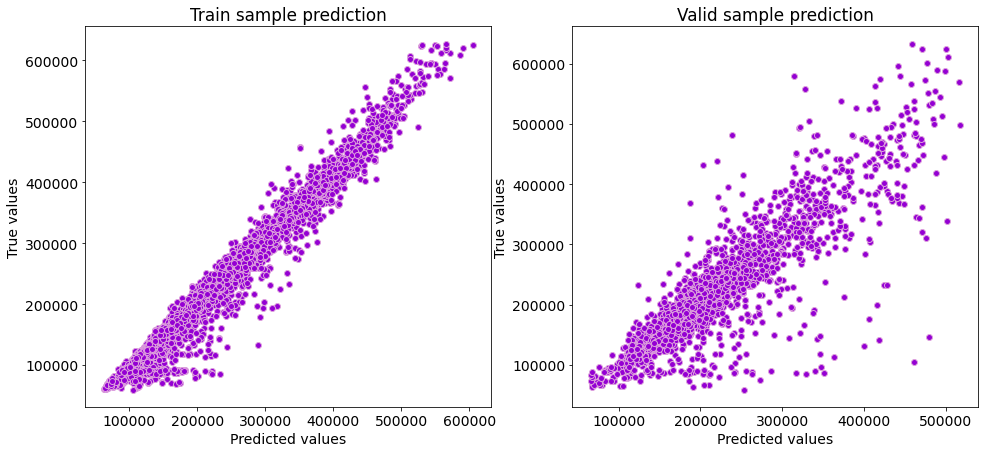

In [106]:
y_train_preds = rf_model.predict(X_train)
y_valid_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

### Кросс-валидация

In [107]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.72420699, 0.73199023, 0.73909558])

In [108]:
cv_score.mean()

0.7317642661243676

### Оценка важности признаков

In [109]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
3,Square,0.321063
19,DistrictPricePerSqM,0.310794
4,LifeSquare,0.124100
2,Rooms,0.030771
5,KitchenSquare,0.025750
0,Id,0.023190
8,HouseYear,0.023156
7,HouseFloor,0.018690
6,Floor,0.016257
1,DistrictId,0.013345


## Применение модели к тестовому набору данных и загрузка предсказаний в файл

In [110]:
submit = pd.read_csv(SUBMISSION_PATH)
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [114]:
predicts = rf_model.predict(test_df)
predicts

array([150324.36055344, 105964.32316454, 141061.22511033, ...,
       148278.32493033, 187187.22295381, 281284.45667171])

In [115]:
submit['Price'] = predicts
submit.head()

,Id,Price
0,4567,150324.360553
1,5925,105964.323165
2,960,141061.225110
3,3848,124028.001343
4,746,173746.565597


In [116]:
submit.to_csv('C:/Python_Ed/Python_Libraries/Course_Project/project_data_from_kaggle/AKorneev_predictions.csv', index=False)